In [2]:
import h5py
import matplotlib.pyplot as plt
import meep as mp
import numpy as np
import os

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Increase the default resolution for images
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Plot everything on a dark background
plt.style.use('dark_background')

# Some custom colormaps
cmap_alpha = LinearSegmentedColormap.from_list(
    'custom_alpha', [[1, 1, 1, 0], [1, 1, 1, 1]])
cmap_blue = LinearSegmentedColormap.from_list(
    'custom_blue', [[0, 0, 0], [0, 0.66, 1], [1, 1, 1]])

def label_plot(ax, title=None, xlabel=None, ylabel=None, elapsed=None):
    """
    Add a title and x/y labels to the plot.
    """
    if title:
        ax.set_title(title)
    elif elapsed is not None:
        ax.set_title(f'{elapsed:0.1f} fs')
    if xlabel is not False:
        ax.set_xlabel('x (μm)'if xlabel is None else xlabel)
    if ylabel is not False:
        ax.set_ylabel('y (μm)'if ylabel is None else ylabel)

def plot_eps_data(eps_data, domain, ax=None, **kwargs):
    """
    Plot the wall geometry (dielectric data) within the domain.
    """
    ax = ax or plt.gca()
    ax.imshow(eps_data.T, cmap=cmap_alpha, extent=domain, origin='lower')
    label_plot(ax, **kwargs)

def plot_ez_data(ez_data, domain, ax=None, vmax=None, aspect=None, **kwargs):
    """
    Plot the amplitude of the complex-valued electric field
    data within the domain.
    """
    ax = ax or plt.gca()
    ax.imshow(
        np.abs(ez_data.T),
        interpolation='spline36',
        cmap=cmap_blue,
        extent=domain,
        vmax=vmax,
        aspect=aspect,
        origin='lower',
        )
    label_plot(ax, **kwargs)

def plot_pml(pml_thickness, domain, ax=None):
    ax = ax or plt.gca()
    x_start = domain[0] + pml_thickness
    x_end = domain[1] - pml_thickness
    y_start = domain[2] + pml_thickness
    y_end = domain[3] - pml_thickness
    rect = plt.Rectangle(
        (x_start, y_start),
        x_end - x_start,
        y_end - y_start,
        fill=None,
        color='#fff',
        linestyle='dashed',
        )
    ax.add_patch(rect)

In [5]:
# The speed of light in μm/fs
SOL = 299792458e-9

# 2D spatial domain measured in μm
domain = [0, 30, -10, 10]
center = mp.Vector3(
    (domain[1] + domain[0]) / 2,
    (domain[3] + domain[2]) / 2,
    )
cell_size = mp.Vector3(
    domain[1] - domain[0],
    domain[3] - domain[2],
    )

In [6]:
# Dimensions of wall with two apertures
wall_position = 10
wall_thickness = 0.5
aperture_width = 1
inner_wall_len = 4  # wall separating the apertures
outer_wall_len = (
    cell_size[1]
    - 2*aperture_width
    - inner_wall_len
    ) / 2

# Define a wall material with high dielectric constant,
# effectively blocking light and reflecting it instead
material = mp.Medium(epsilon=1e6)

# Define the wall as an array of 3 blocks arranged vertically
geometry = [
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center=mp.Vector3(
            wall_position - center.x,
            domain[3] - outer_wall_len / 2),
        material=material),
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center=mp.Vector3(
            wall_position - center.x,
            domain[2] + outer_wall_len / 2),
        material=material),
    mp.Block(
        mp.Vector3(wall_thickness, inner_wall_len, mp.inf),
        center=mp.Vector3(wall_position - center.x, 0),
        material=material),
    ]

# Perfectly matched layer of thickness 1
pml_thickness = 1
pml_layers = [mp.PML(pml_thickness)]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000459909 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 10
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.0855081 s
-----------


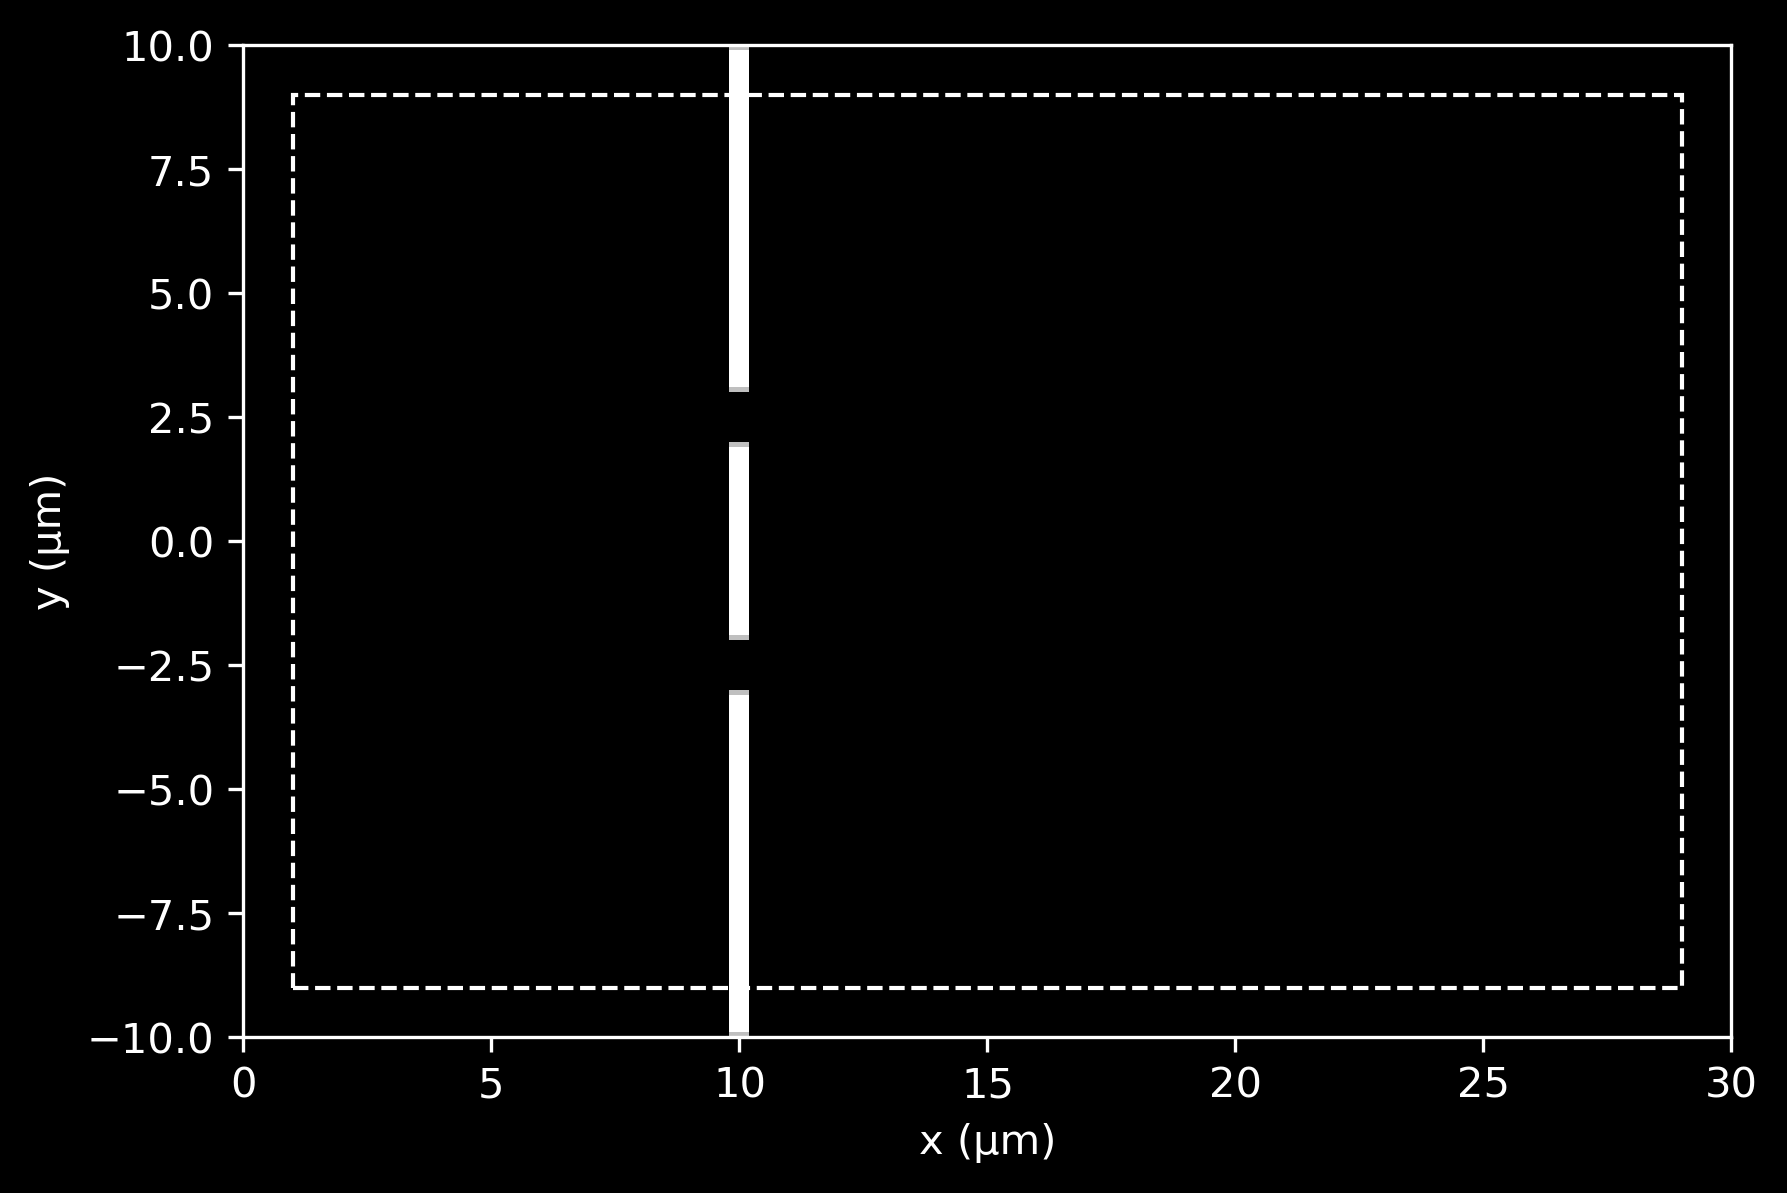

In [7]:
# Extract and visualize the dielectric data (wall geometry)
sim = mp.Simulation(cell_size=cell_size, geometry=geometry, resolution=10)
sim.init_sim()
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
ax = plt.gca()
plot_pml(pml_thickness, domain, ax=ax)
plot_eps_data(eps_data, domain, ax=ax)

In [8]:
# Light wavelength, frequency, and beam width
source_lambda = 0.47  # in μm
source_frequency = 1 / source_lambda
source_beam_width = 6

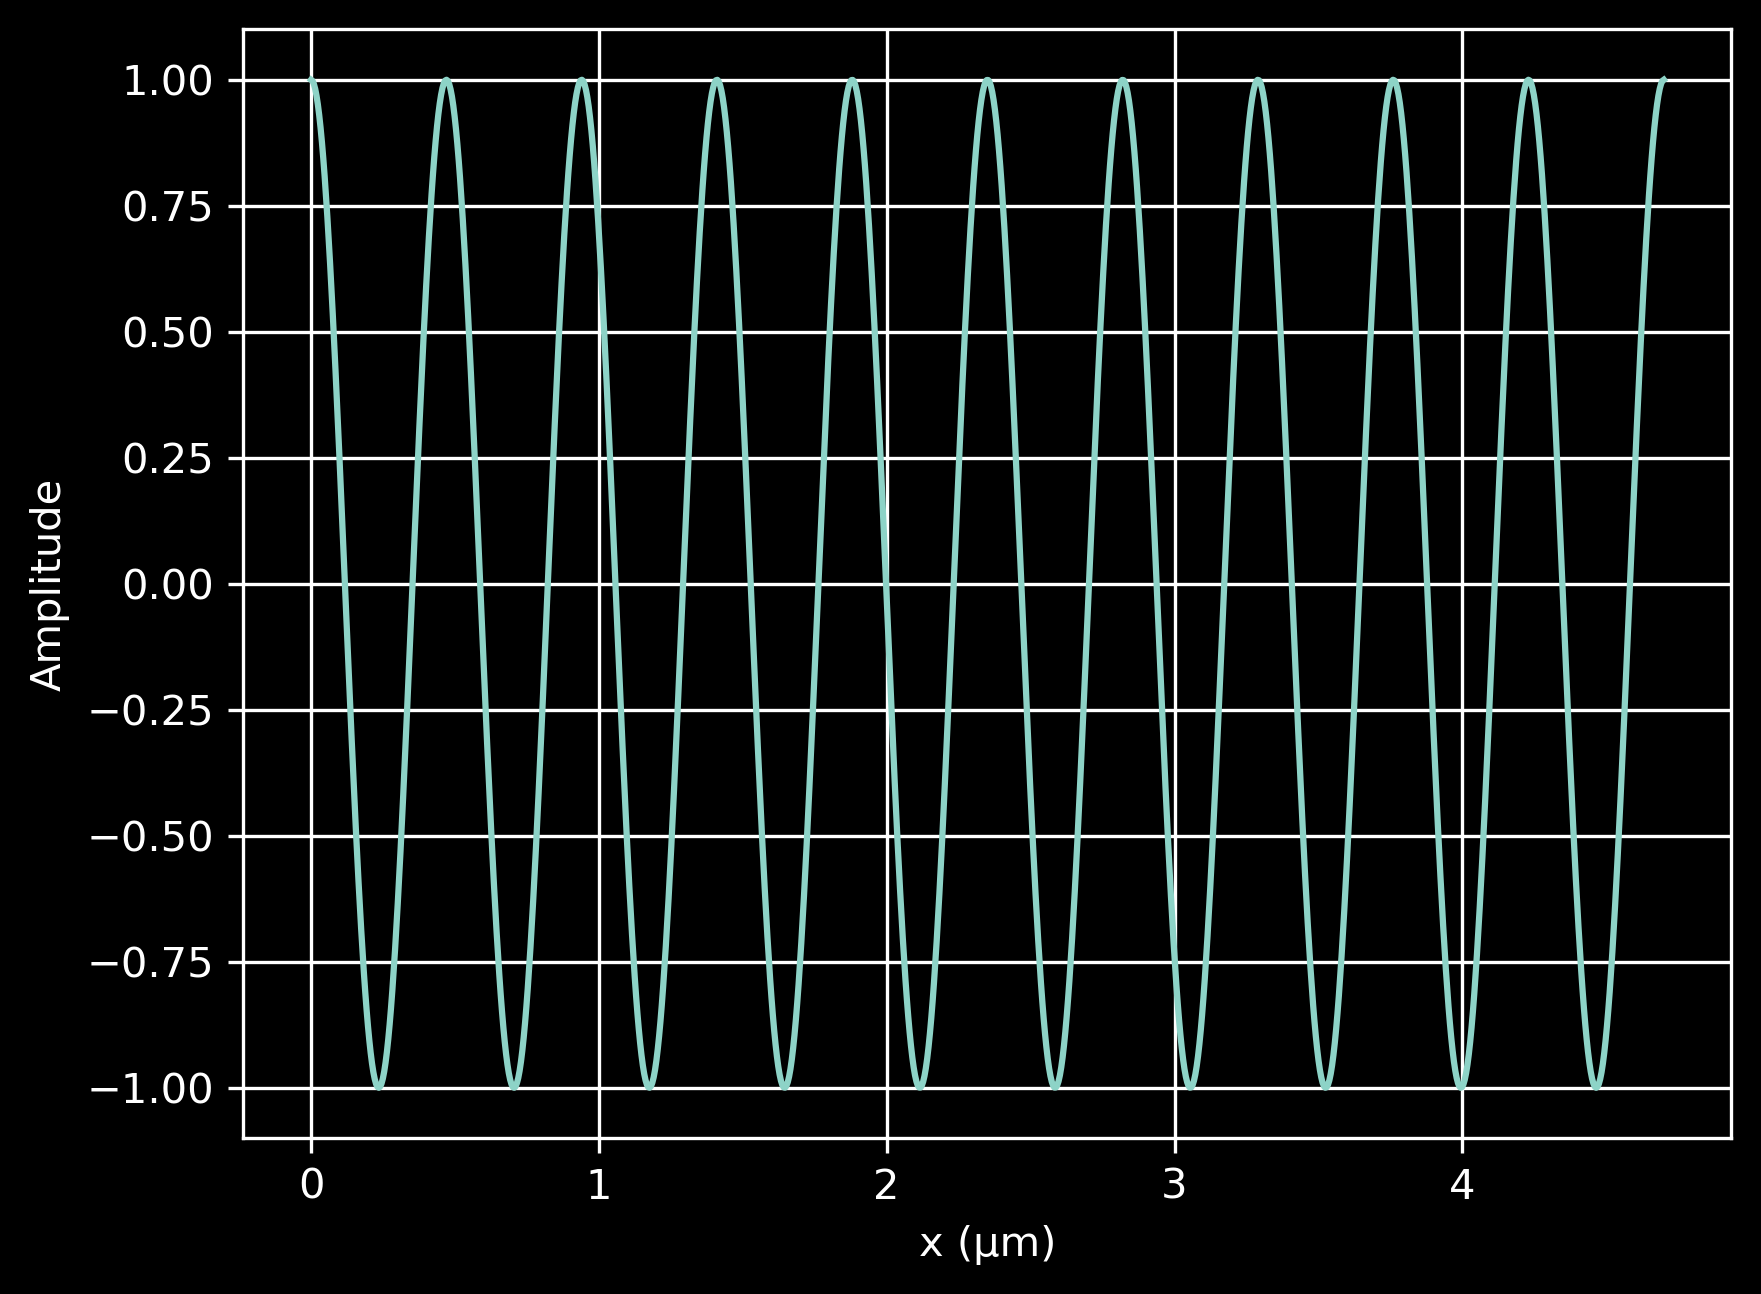

In [9]:
# A method to return a complex-valued plane wave in the x-direction
def plane_wave(x):
    return np.exp(2j * np.pi / source_lambda * x)

# Plot the plane wave
xarr = np.linspace(0, 10*source_lambda, 1000)
wave = plane_wave(xarr)
plt.plot(xarr, wave.real)
plt.xlabel('x (μm)')
plt.ylabel('Amplitude')
plt.grid(True)

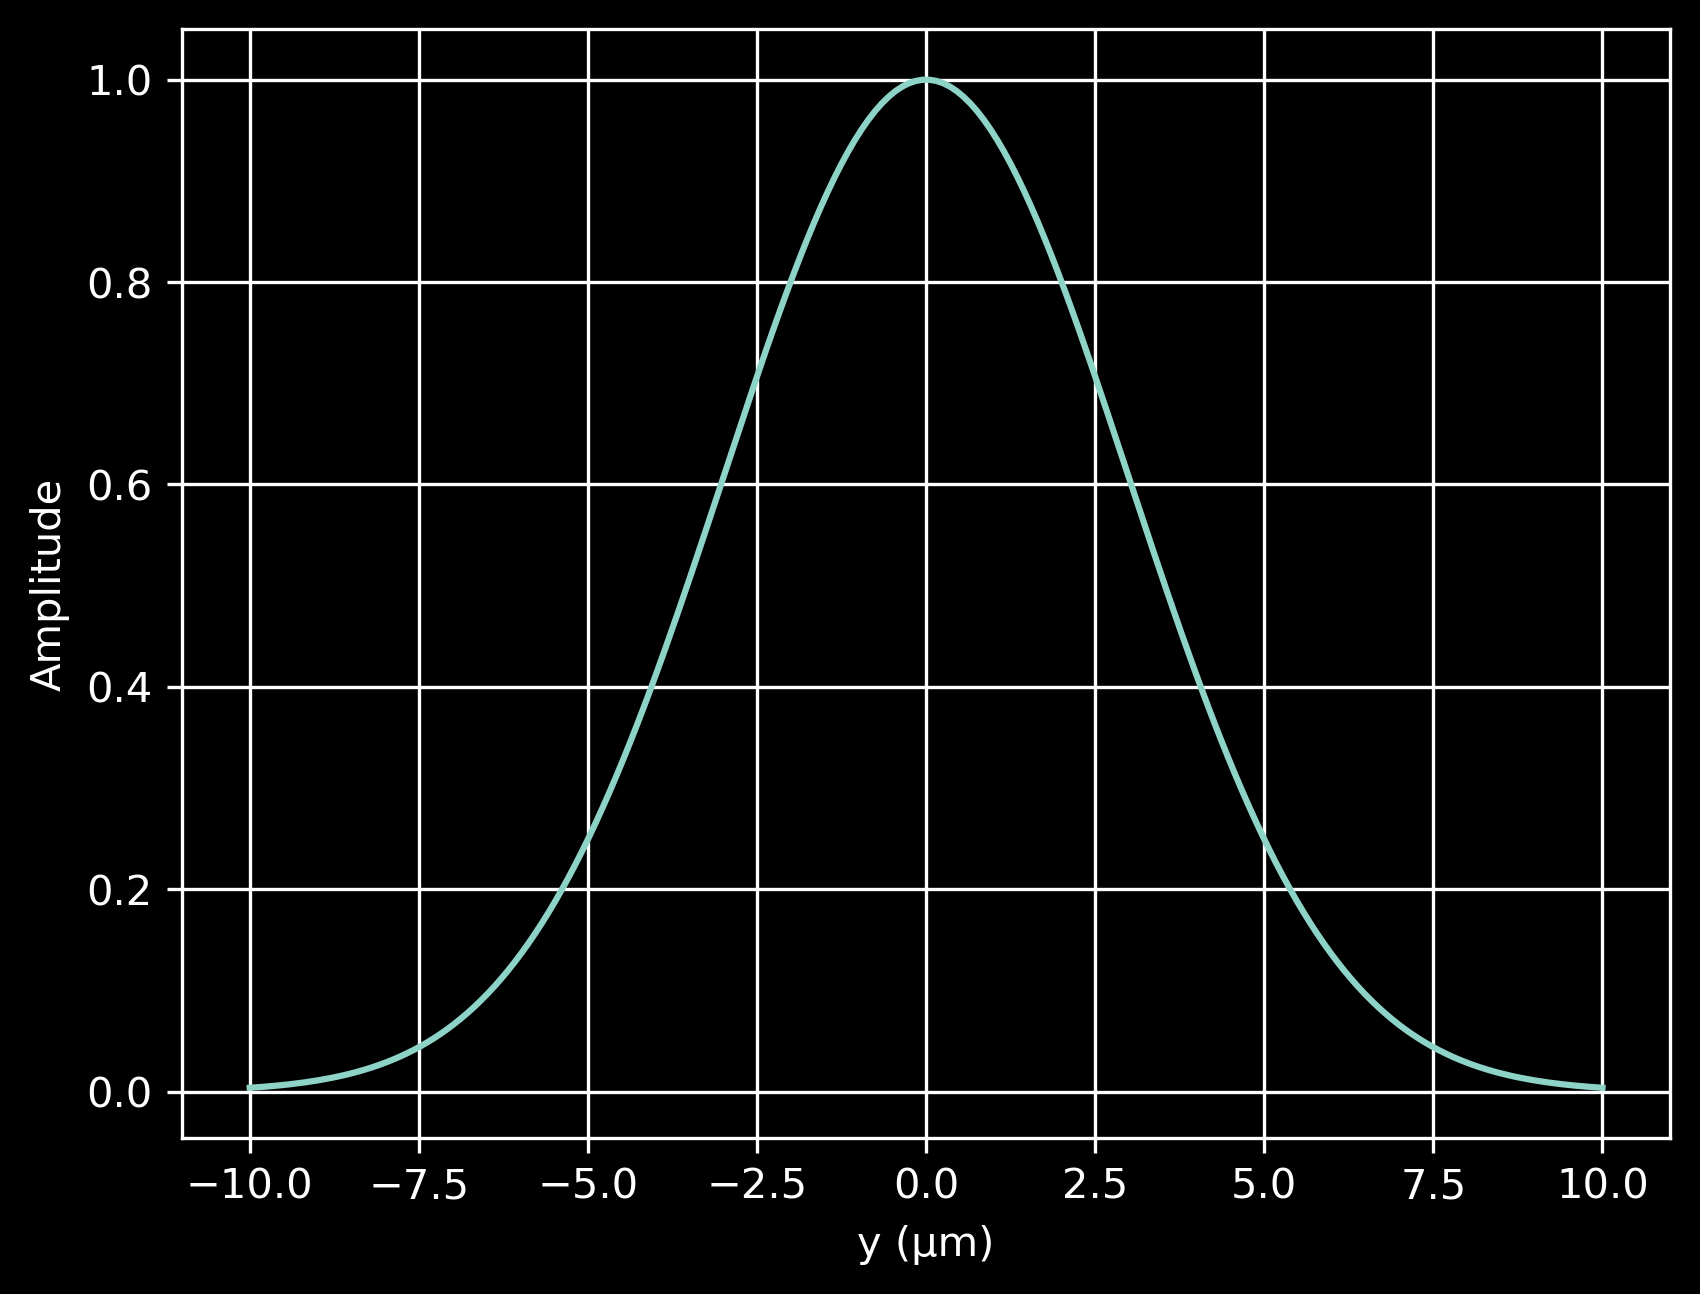

In [10]:
# A method to compute the Gaussian profile in the y-direction
def gaussian_profile(y):
    return np.exp(-y**2 / (2 * (source_beam_width / 2)**2))

# Plot the Guassian profile
yarr = np.linspace(domain[2], domain[3], 200)
prof = gaussian_profile(yarr)
plt.plot(yarr, prof)
plt.xlabel('y (μm)')
plt.ylabel('Amplitude')
plt.grid(True)

Text(0, 0.5, 'y (μm)')

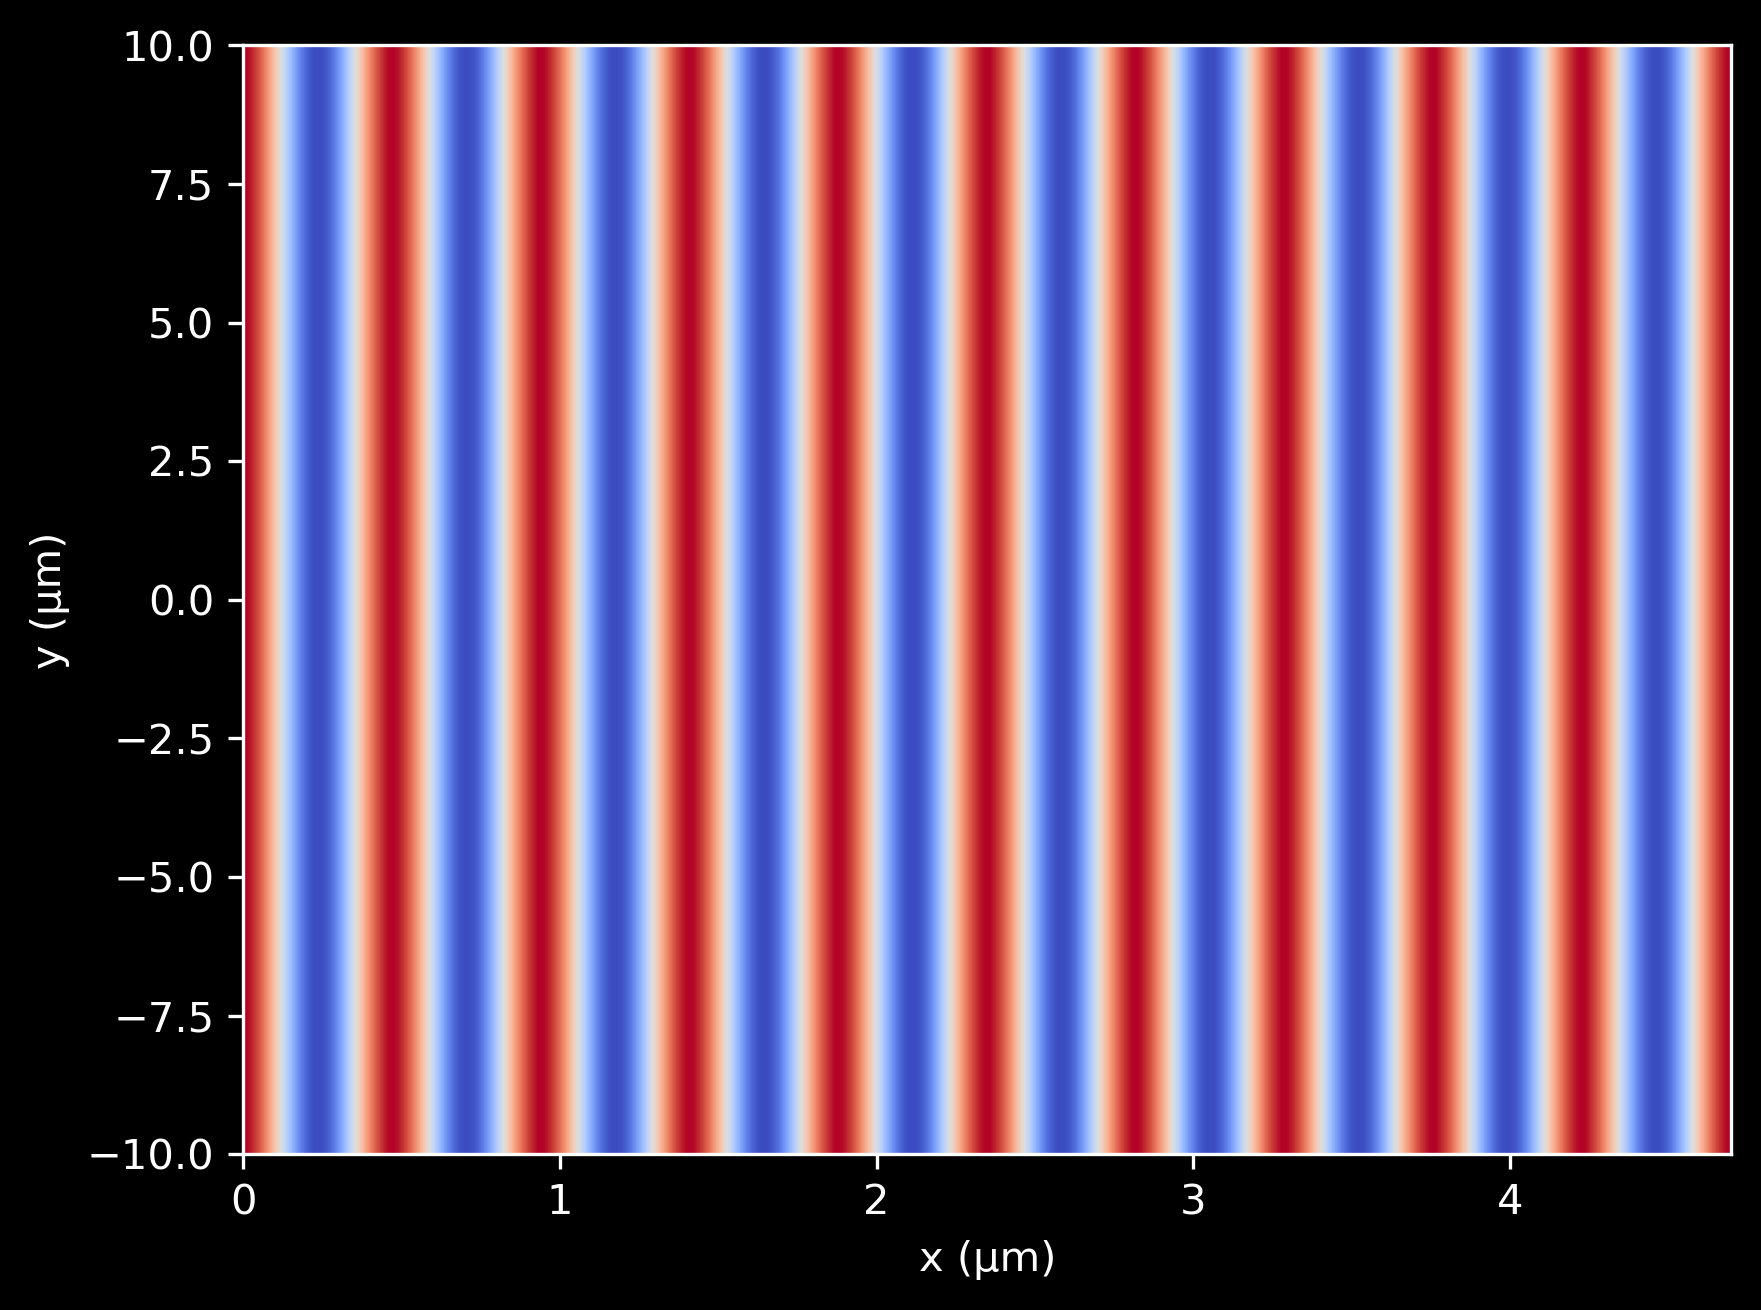

In [ ]:
# A 2D grid of points
X, Y = np.meshgrid(xarr, yarr)

# Plot the combined terms
combined = plane_wave(X) * gaussian_profile(Y)
plt.imshow(
    np.real(combined),
    cmap='coolwarm',
    aspect='auto',
    extent=[xarr[0], xarr[-1], yarr[0], yarr[-1]],
    origin='lower',
    )
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')

In [13]:
def amp_func(pos):
    return plane_wave(pos[0]) * gaussian_profile(pos[1])

source = mp.Source(
    src=mp.ContinuousSource(
        frequency=source_frequency,
        is_integrated=True,
        ),
    component=mp.Ez,
    center= mp.Vector3(1, 0, 0) - center,  # positioned far-left, excluding PML
    size=mp.Vector3(y=cell_size[1]),       # span entire height, including PML
    amp_func=amp_func,
    )

In [14]:
# Define resolution in terms of smallest component
smallest_length = min(
    source_lambda,
    wall_thickness,
    aperture_width,
    inner_wall_len,
)
pixel_count = 10
resolution = int(np.ceil(pixel_count / smallest_length))
print('Simulation resolution:', resolution)

Simulation resolution: 22


-----------
Initializing structure...
time for choose_chunkdivision = 0.000529051 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.32884 s
-----------
Meep: using complex fields.
Meep progress: 20.727272727272727/40.0 = 51.8% done in 4.0s, 3.7s to go
on time step 912 (time=20.7273), 0.00439104 s/step
run 0 finished at t = 40.0 (1760 timesteps)


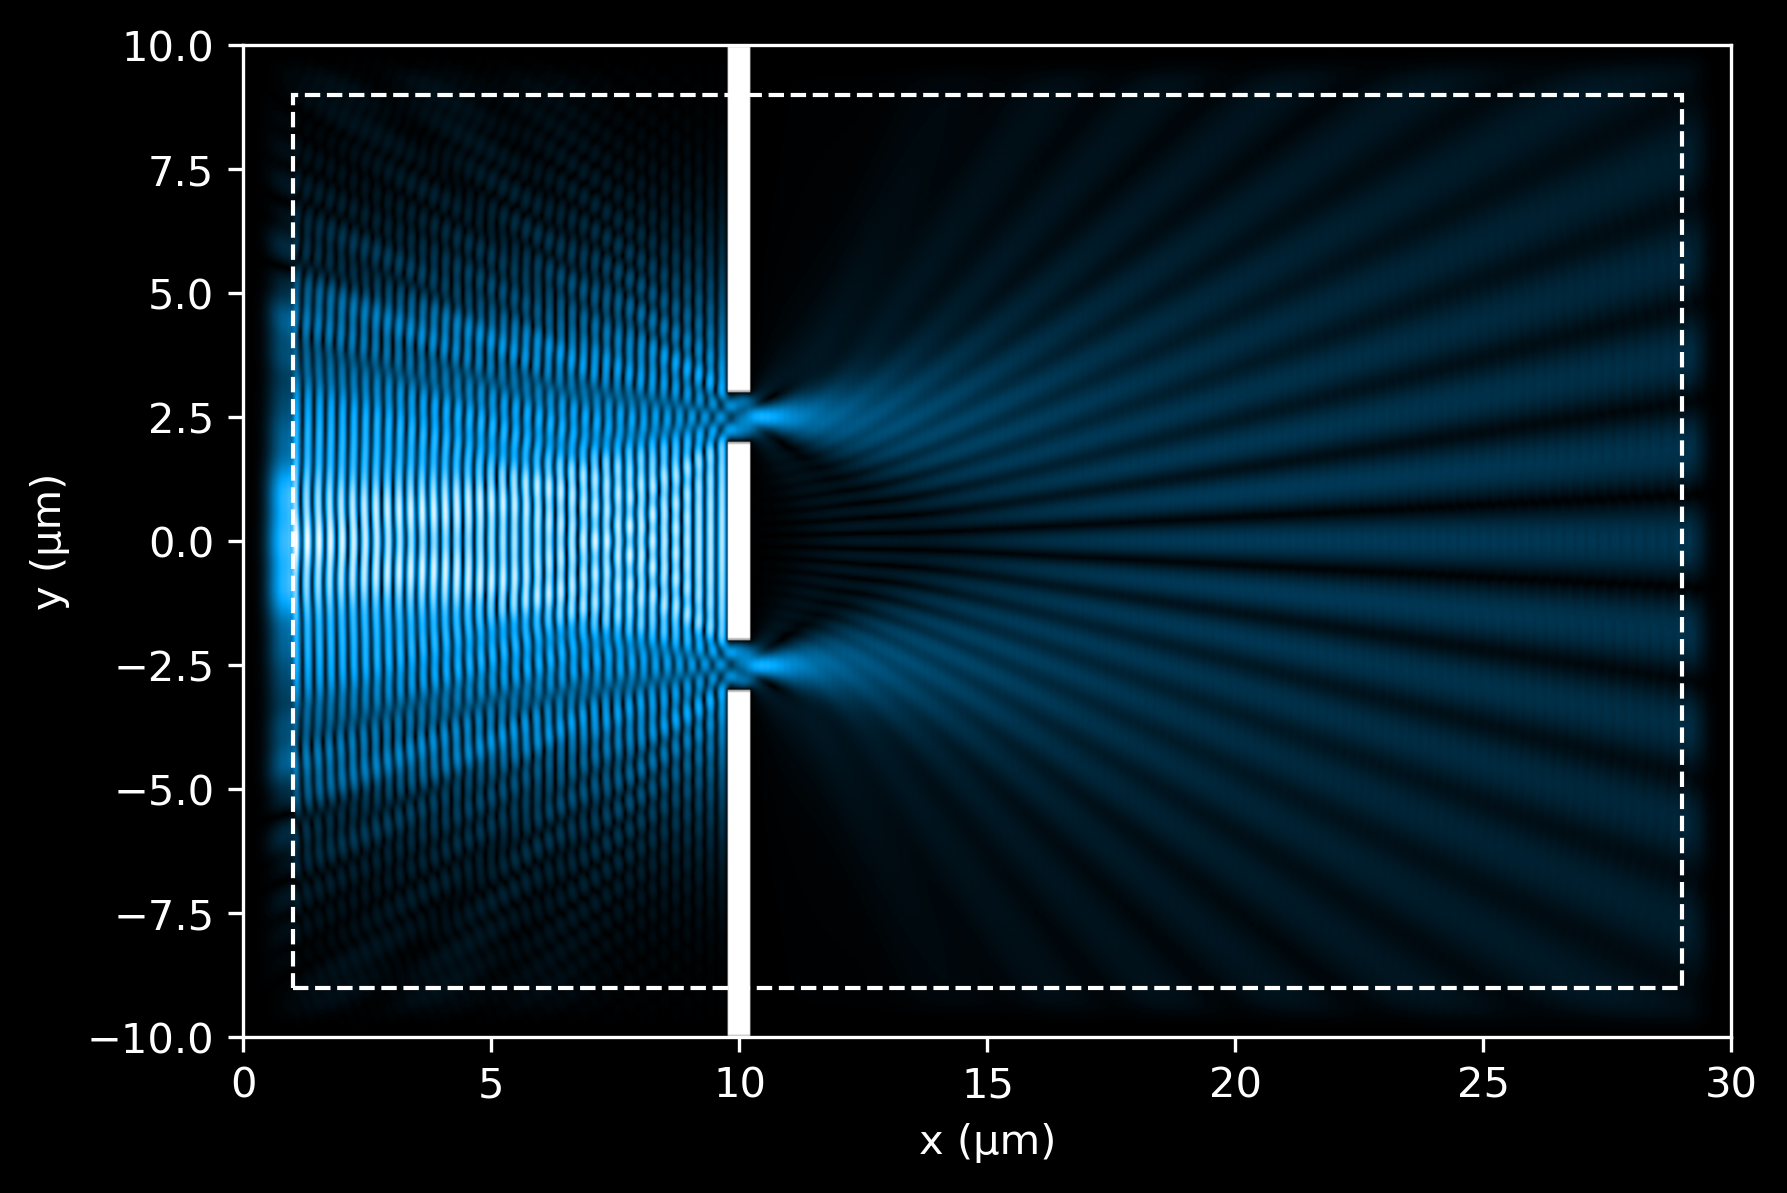

In [16]:
# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    sources=[source],
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    force_complex_fields=True,
    )

# Convenience method to extract Ez and dielectric data
def get_data(sim, cell_size):
    ez_data = sim.get_array(
        center=mp.Vector3(), size=cell_size, component=mp.Ez)
    eps_data = sim.get_array(
        center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
    return ez_data, eps_data
    
# Run simulation until light travels full length (plus some)
sim.run(until=cell_size[0] + 10)
ez_data, eps_data = get_data(sim, cell_size)

# Plot simulation
ax = plt.gca()
plot_ez_data(ez_data, domain, ax=ax)
plot_eps_data(eps_data, domain, ax=ax)
plot_pml(pml_thickness, domain, ax=ax)

In [17]:
# Sim duration and number of snapshots
sim_time = 120  # in fs
n_frames = 6

# Where to save the results
sim_path = 'simulation.h5'

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    sources=[source],
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    force_complex_fields=True,
    )

def simulate(sim, sim_path, sim_time, n_frames):
    
    # Remove previous sim file, if any
    if os.path.exists(sim_path):
        os.remove(sim_path)

    # Time delta (in fs) between snapshots. Note that
    # we subtract 1 because we include the initial state
    # as the first frame.
    fs_delta = sim_time / (n_frames - 1)
    
    # Save data to an HDF5 binary file
    with h5py.File(sim_path, 'a') as f:
    
        # Save simulation params for future reference
        f.attrs['sim_time'] = sim_time
        f.attrs['n_frames'] = n_frames
        f.attrs['fs_delta'] = fs_delta
        f.attrs['resolution'] = sim.resolution
        
        # Save initial state as first frame
        sim.init_sim()
        ez_data, eps_data = get_data(sim, cell_size)
        f.create_dataset(
            'ez_data',
            shape=(n_frames, *ez_data.shape),
            dtype=ez_data.dtype,
            )
        f.create_dataset(
            'eps_data',
            shape=eps_data.shape,
            dtype=eps_data.dtype,
            )
        f['ez_data'][0]  = ez_data
        f['eps_data'][:] = eps_data
    
        # Simulate and capture remaining snapshots
        for i in range(1, n_frames):
    
            # Run until the next frame time
            sim.run(until=SOL * fs_delta)
    
            # Capture electral field data    
            ez_data, _ = get_data(sim, cell_size)
            f['ez_data'][i]  = ez_data

simulate(sim, sim_path, sim_time, n_frames)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000344992 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.367621 s
-----------
Meep: using complex fields.
run 0 finished at t = 7.204545454545455 (317 timesteps)
run 1 finished at t = 14.40909090909091 (634 timesteps)
on time step 781 (time=17.75), 0.0051217 s/step
run 2 finished at t = 21.613636363636363 (951 timesteps)
run 3 finished at t = 28.818181818

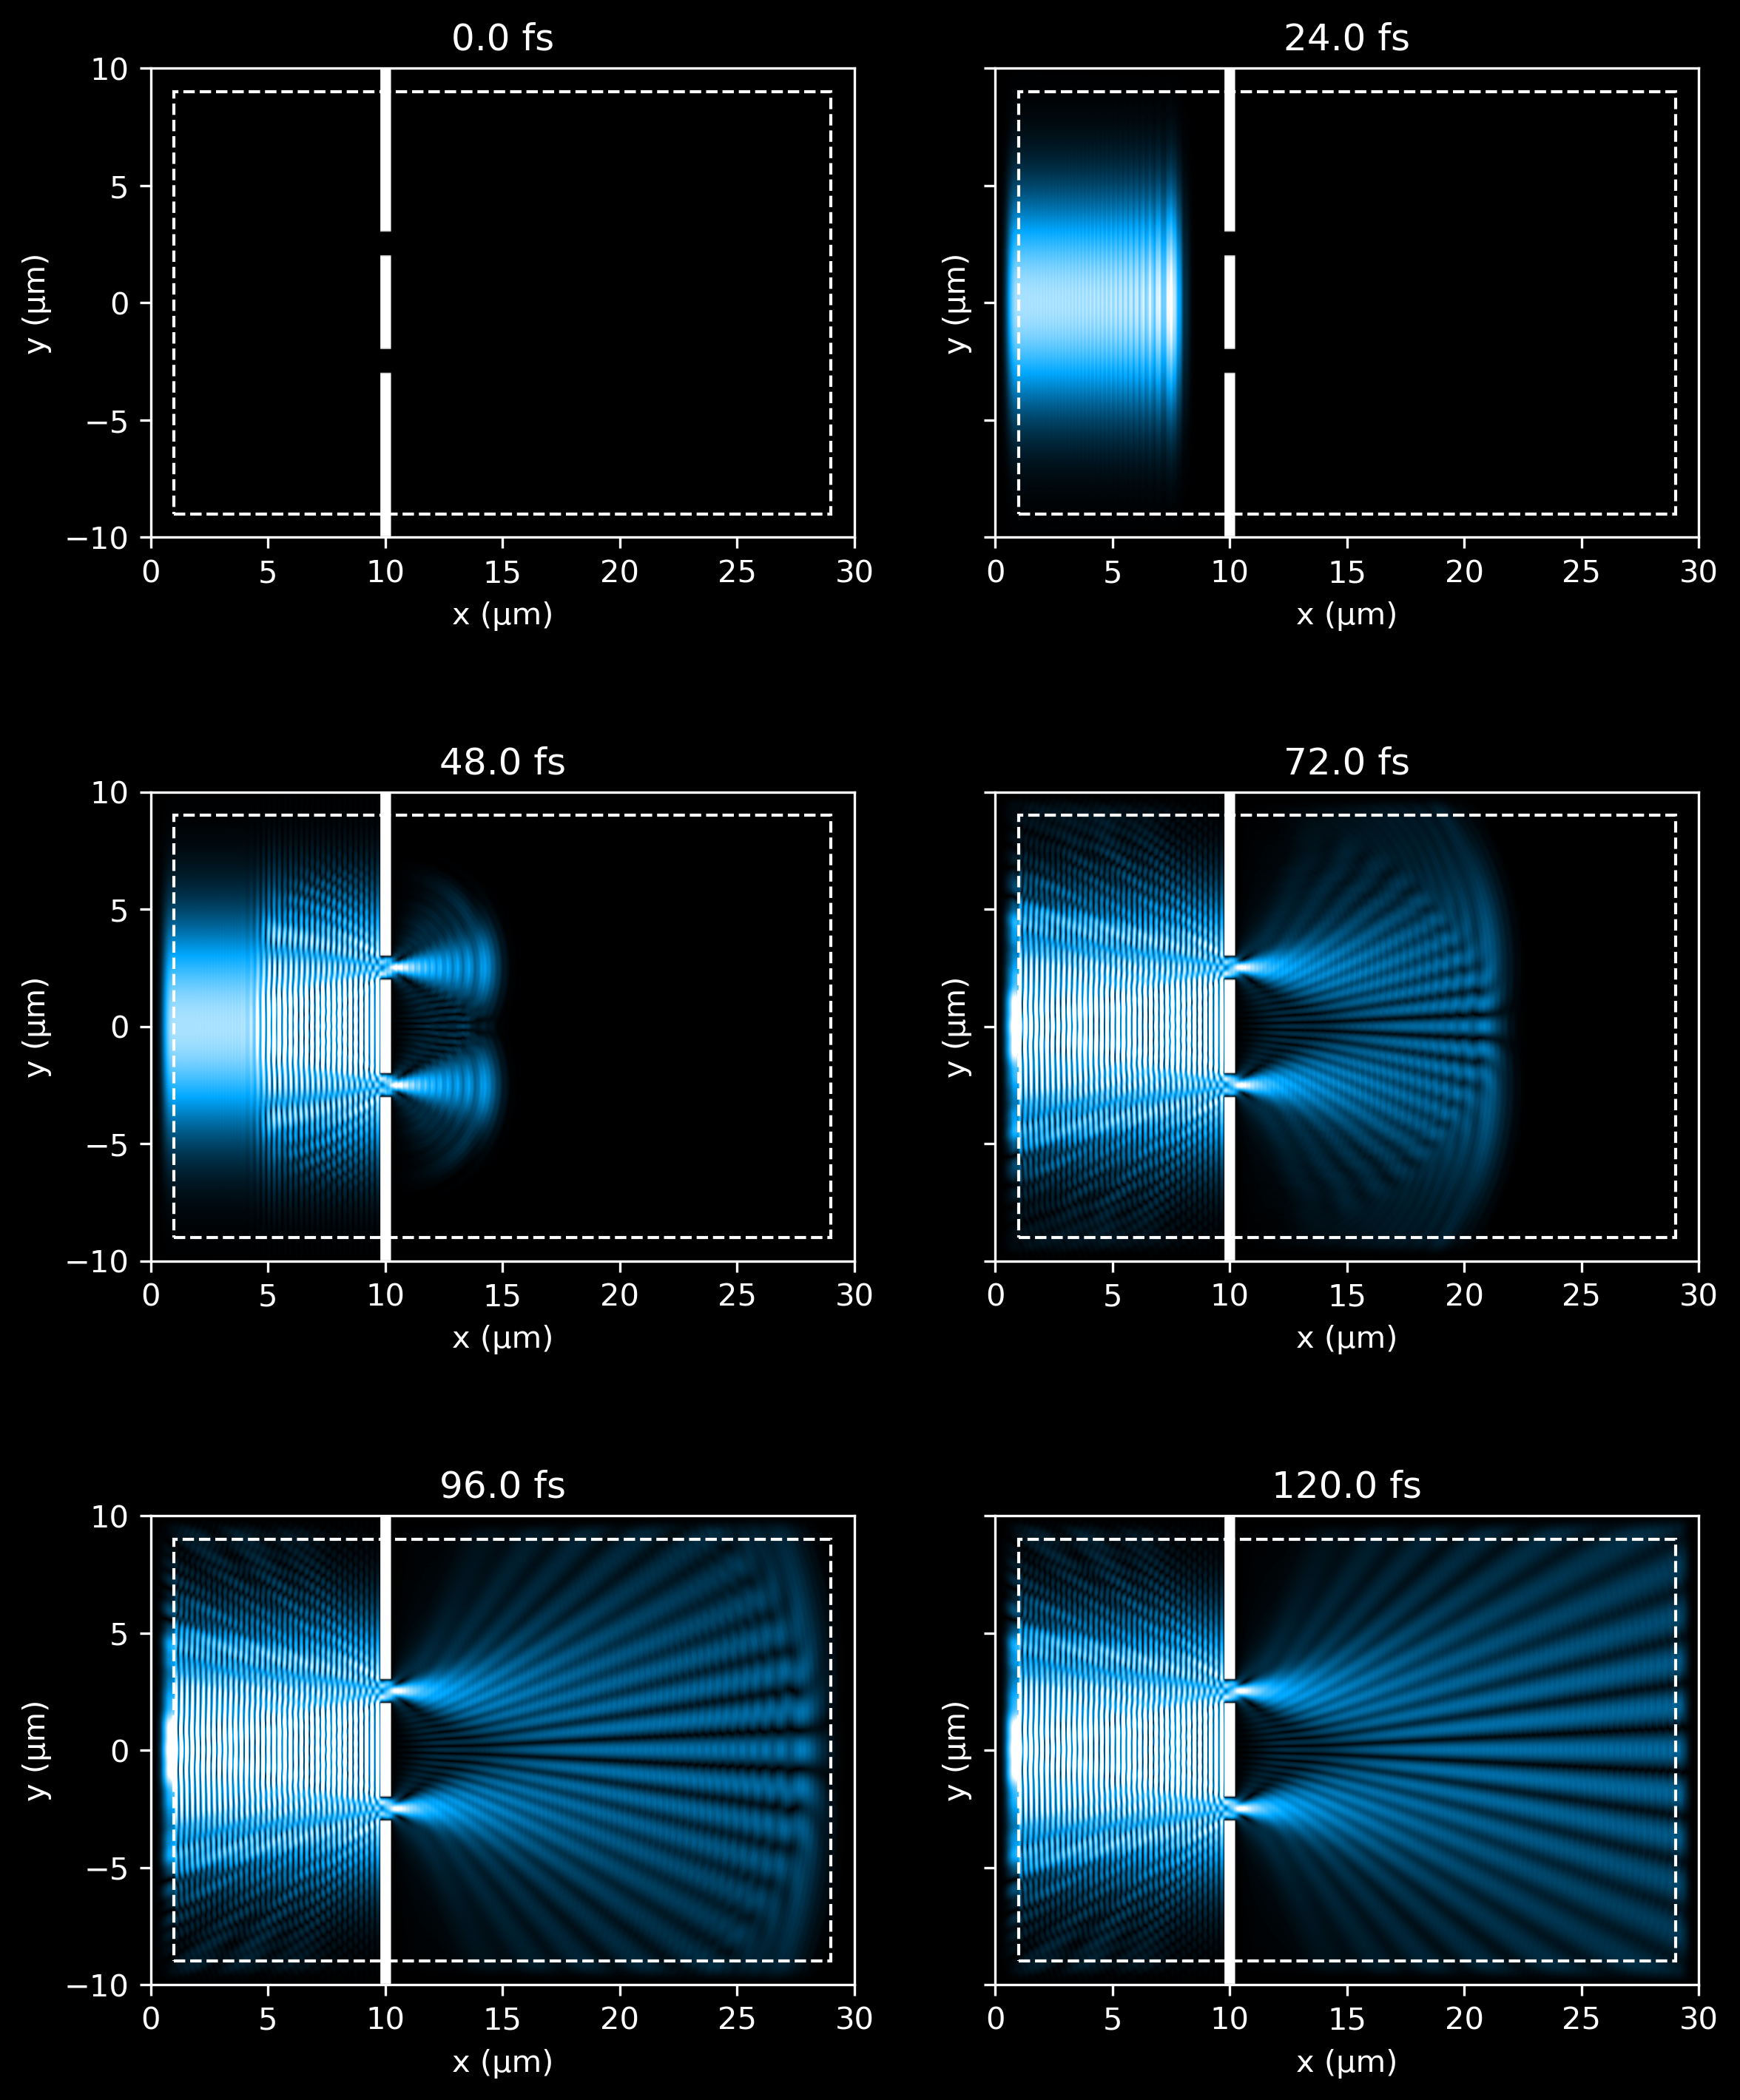

In [18]:
fig_rows = 3
fig_cols = 2
n_subplots = fig_rows * fig_cols
fig, ax = plt.subplots(
    fig_rows,
    fig_cols,
    figsize=(9, 12),
    sharex=False,
    sharey=True,
    )

with h5py.File(sim_path, 'r') as f:
    for k in range(n_subplots):
        i, j = int(k / fig_cols), (k % fig_cols)
        # i, j = (k % fig_rows), int(k / fig_rows)
        _ax = ax[i][j]
        ez_data = f['ez_data'][k]
        eps_data = f['eps_data'][:]
        elapsed = k * f.attrs['fs_delta']
        vmax = 0.6  # force consistent brightness
        plot_ez_data(ez_data, domain, ax=_ax, vmax=vmax, elapsed=elapsed)
        plot_eps_data(eps_data, domain, ax=_ax)
        plot_pml(pml_thickness, domain, ax=_ax)